# Appling machine learning to audio analysis

### Trainning Code

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2022-01-06 11:18:09.790720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 11:18:09.790773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# To play audio file:
import IPython.display as ipd

In [5]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/1e74e70e395f4092a32f667759bea71d



## MFCCs - Mel-Frequency Cepstrum Coefficients

### Function to extract the MFCCs from every file in our dataset

In [6]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [7]:
df = pd.read_csv('../csvFiles/newTiming.csv')

In [8]:
from os.path import exists

In [9]:
sounds = []# Iterate through each sound file and extract the sound type
cont = 0
i =0
for index, row in df.iterrows():
    file_name = df.loc[index]['fname']
    label = df.loc[index]['sound']
    if label == 'noiseS2' or label == 'noiseS1':
        class_label = label[:5]
    else:
        class_label = label
    
    i+=1
    
    if (exists(file_name)):
        file_size = os.path.getsize(file_name)
        if (file_size>44):
            data = extract_features(file_name)
            sounds.append([data, class_label])
            cont += 1
        else:
            print(file_name)
            
print(i, cont)
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(sounds, columns=['soundtype','class_label'])

/home/chico/Desktop/taad/projeto/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1750
  warnings.warn(
/home/chico/Desktop/taad/projeto/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1751
  warnings.warn(
/home/chico/Desktop/taad/projeto/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1222
  warnings.warn(
/home/chico/Desktop/taad/projeto/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1122
  warnings.warn(
/home/chico/Desktop/taad/projeto/taad-project/env/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1888
  warnings.warn(
/home/chico/Desktop/taad/proje

801 800


In [10]:
featuresdf

,soundtype,class_label
0,"[-328.07162, 138.91454, 7.4351997, 23.263115, ...",S1
1,"[-336.12396, 131.63614, 9.702477, 21.125206, 1...",S2
2,"[-331.10678, 136.21701, 10.334246, 22.4966, 19...",S1
3,"[-335.80725, 123.60682, -1.5984118, 20.42966, ...",S2
4,"[-325.8048, 132.97308, 3.1069694, 14.60768, 16...",S1
...,...,...
795,"[-589.4596, 139.04172, 66.54428, 28.739033, 36...",noise
796,"[-578.94, 136.67522, 62.54581, 27.189838, 40.6...",noise
797,"[-576.6643, 132.03662, 73.05437, 37.617058, 33...",noise
798,"[-612.7163, 152.76172, 69.798096, 28.356243, 3...",noise


In [11]:
featuresdf.iloc[0]['soundtype']

array([-3.28071625e+02,  1.38914536e+02,  7.43519974e+00,  2.32631149e+01,
        1.71740608e+01,  3.20958672e+01,  1.05726299e+01,  9.93866158e+00,
        3.27157640e+00,  1.13862600e+01, -1.64056945e+00,  2.71055484e+00,
       -4.19648981e+00,  1.15103111e+01,  5.94600677e+00,  8.44897366e+00,
        2.22832561e+00,  3.84371185e+00, -2.79735148e-01,  2.97816753e+00,
       -8.05911636e+00,  1.60247874e+00, -1.08846283e+00,  2.79894257e+00,
       -2.16024780e+00,  2.65338135e+00, -7.26681113e-01,  4.09988737e+00,
       -1.07068396e+00,  2.64572072e+00, -2.86918068e+00, -1.63719678e+00,
       -3.54085565e+00,  1.43643880e+00, -3.17849040e+00,  1.05118036e-01,
       -3.79147911e+00,  1.88193858e+00,  3.63390064e+00,  2.12384558e+00],
      dtype=float32)

../set_a_cut/normal__201102081321_noiseS1_11.wav


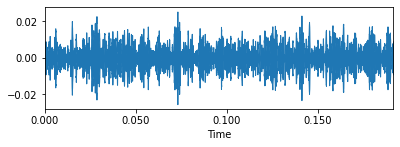

In [12]:
fig = plt.figure(figsize=(15,15))
#experiment.log_image('label_examples.png')
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

fig.add_subplot(6,2,1)
name = df.loc[411]['fname']
print(name)
data, sample_rate = librosa.load(name)
librosa.display.waveplot(data, sr = sample_rate)
dad = extract_features(name)
sounds.append([dad,df.loc[411]['sound']])
    
featuresdf = pd.DataFrame(sounds, columns=['soundtype','class_label'])

## Model building and training

In [13]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.soundtype.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

### Trainning and test sets

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

### Neural Network architecture

In [15]:
num_labels = yy.shape[1]

filter_size = 2

def build_model_graph(input_shape=(40,)):
    model = Sequential()
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
    
    return model

model = build_model_graph()

# Display model architecture summary 
model(x_train)
model.summary()# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

2022-01-06 11:19:38.062323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-06 11:19:38.062391: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-06 11:19:38.062440: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (chico-VirtualBox): /proc/driver/nvidia/version does not exist
2022-01-06 11:19:38.065059: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (640, 512)                20992     
                                                                 
 activation (Activation)     (640, 512)                0         
                                                                 
 dropout (Dropout)           (640, 512)                0         
                                                                 
 dense_1 (Dense)             (640, 512)                262656    
                                                                 
 activation_1 (Activation)   (640, 512)                0         
                                                                 
 dropout_1 (Dropout)         (640, 512)                0         
                                                                 
 dense_2 (Dense)             (640, 512)                2

### Model Trainning

In [18]:
num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Epoch 1/100
20/20 [==============================] - 1s 33ms/step - loss: 0.4562 - accuracy: 0.8125 - val_loss: 0.4889 - val_accuracy: 0.7826
Epoch 2/100
20/20 [==============================] - 1s 35ms/step - loss: 0.4356 - accuracy: 0.8031 - val_loss: 0.4904 - val_accuracy: 0.7391
Epoch 3/100
20/20 [==============================] - 1s 35ms/step - loss: 0.4394 - accuracy: 0.8062 - val_loss: 0.4850 - val_accuracy: 0.7826
Epoch 4/100
20/20 [==============================] - 1s 33ms/step - loss: 0.4032 - accuracy: 0.8094 - val_loss: 0.5091 - val_accuracy: 0.7764
Epoch 5/100
20/20 [==============================] - 1s 32ms/step - loss: 0.4217 - accuracy: 0.8016 - val_loss: 0.5040 - val_accuracy: 0.7950
Epoch 6/100
20/20 [==============================] - 1s 35ms/step - loss: 0.3994 - accuracy: 0.8281 - val_loss: 0.5118 - val_accuracy: 0.7702
Epoch 7/100
20/20 [==============================] - 1s 33ms/step - loss: 0.3890 - accuracy: 0.8250 - val_loss: 0.5068 - val_accuracy: 0.7764
Epoch 

20/20 [==============================] - 1s 26ms/step - loss: 0.3771 - accuracy: 0.8391 - val_loss: 0.5088 - val_accuracy: 0.7826
Epoch 59/100
20/20 [==============================] - 1s 35ms/step - loss: 0.3505 - accuracy: 0.8438 - val_loss: 0.5534 - val_accuracy: 0.7950
Epoch 60/100
20/20 [==============================] - 0s 23ms/step - loss: 0.3825 - accuracy: 0.8266 - val_loss: 0.5626 - val_accuracy: 0.8199
Epoch 61/100
20/20 [==============================] - 1s 29ms/step - loss: 0.4185 - accuracy: 0.8266 - val_loss: 0.4890 - val_accuracy: 0.8075
Epoch 62/100
20/20 [==============================] - 1s 28ms/step - loss: 0.3563 - accuracy: 0.8250 - val_loss: 0.5082 - val_accuracy: 0.8323
Epoch 63/100
20/20 [==============================] - 1s 28ms/step - loss: 0.3423 - accuracy: 0.8391 - val_loss: 0.4922 - val_accuracy: 0.8012
Epoch 64/100
20/20 [==============================] - 1s 30ms/step - loss: 0.3787 - accuracy: 0.8438 - val_loss: 0.4915 - val_accuracy: 0.8199
Epoch 65/100

In [22]:
model.save('../model_save/cut_setA', save_format='tf')

INFO:tensorflow:Assets written to: ../model_save/cut_setA/assets


In [20]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/negromontebs/seta/1e74e70e395f4092a32f667759bea71d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [300]                : (0.3921875059604645, 0.8671875)
COMET INFO:     batch_accuracy [600]          : (0.21875, 0.96875)
COMET INFO:     batch_loss [600]              : (0.16956481337547302, 30.035533905029297)
COMET INFO:     epoch_duration [300]          : (0.39627092400041874, 2.204203442997823)
COMET INFO:     loss [300]                    : (0.3237190544605255, 25.437984466552734)
COMET INFO:     val_accuracy [300]            : (0.43478259444236755, 0.8447204828262329)
COMET INFO:     val_loss [300]                : (0.4414650499820709, 2.7024245262145996)
COMET INFO:     validate_batch_accuracy [300] : (0.375, 0.78125)
COMET